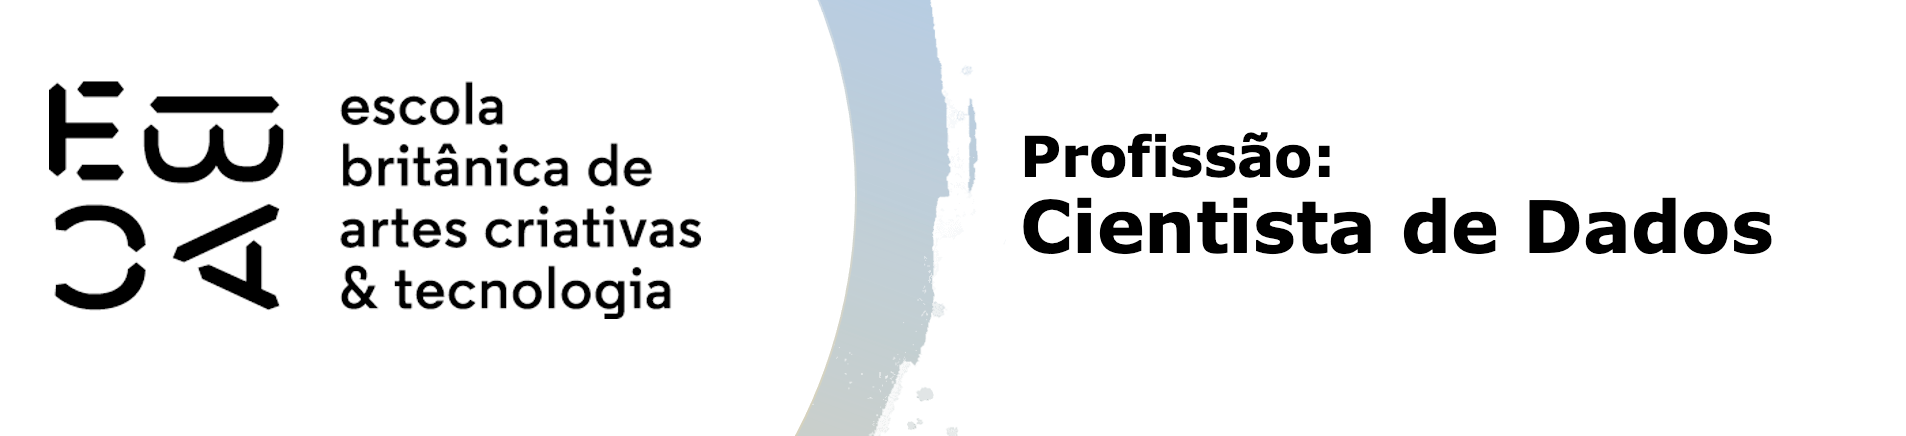

# Tarefa II

Ainda sobre a base da NFP vista na tarefa passada:

|Campo|Descrição|
|:-|:-|
|CNPJ emit.| CNPJ do emitente da nota|
|Emitente| Nome fantasia do emitente da nota|
|No.| Número da nota fiscal|
|Data Emissão| Data de emissão da nota fiscal|
|Valor NF| Valor da nota fiscal|
|Data Registro| Data de registro no sistema da NFP|
|Créditos| Valor dos créditos (doação)|
|Situação do Crédito| Se o crédito já foi pago, está sendo processado etc.|
|Ano| Ano da emissão da nota|
|Semestre| Semestre da emissão da nota|
|Retorno| Valor do crédito dividido pelo valor da nota|
|flag_credito| Indicadora se a nota possui crédito positivo|
|categoria| Categorização da nota |

**OBJETIVO:** Algumas notas não dão retorno, o que pode ocorrer por diversos motivos, um deles seria a ocorrência de produtos não incentivados como cigarros e bebidas alcólicas. O nosso objetivo é tentar prever que tipo de nota tem maior ou menor propensão a fornecer créditos.

**Observação**: Esta é uma base real, havendo características de acordo. Pode haver uma variabilidade difícil de explicar, em parte por causa de uma freqüência de notas inconstante no tempo (por diversos motivos), em parte por haverem informações importantes, protegidas pela LGPD, não constantes na base, que pode interferir no crédito gerado, o que vai ocasionar uma variabilidade difícil de se explicar. *Welcome to the jungle*, A vida real é assim :)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Carregar a base
df = pd.read_pickle('base_nfp.pkl')

# Garantir que Data Emissão é datetime
df['Data Emissão'] = pd.to_datetime(df['Data Emissão'])

# Filtrar para considerar apenas dados a partir de 2020
df = df[df['Data Emissão'] >= '2020-01-01'].copy()

# Criar target se não existir (embora flag_credito já exista, vamos garantir)
df['target'] = (df['Retorno'] > 0).astype(int)

df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,Retorno,flag_credito,categoria,target
64598,05.234.750/0001-41,TX BURGER LTDA,77882,2020-01-01,78.80,2020-08-01,0.0,A Calcular,2019,2,0.0,0,não definido,0
64599,47.508.411/1476-88,CIA BRASILEIRA DE DISTRIBUICAO,20087,2020-01-01,22.71,2020-01-01,0.0,A Calcular,2019,2,0.0,0,Mercado,0
64600,09.060.964/0108-39,PIMENTA VERDE ALIMENTOS LTDA,82366,2020-01-01,35.90,2020-08-01,0.0,A Calcular,2019,2,0.0,0,Alimentos,0
64601,61.412.110/0307-39,DROGARIA SAO PAULO S A,234178,2020-01-01,21.77,2020-08-01,0.0,A Calcular,2019,2,0.0,0,Farmácia,0
64602,46.952.032/0001-98,PANIFICADORA E CONFEITARIA QUELUZ LTDA,3305,2020-01-01,80.95,2020-08-01,0.0,A Calcular,2019,2,0.0,0,Restaurantes,0


## Criando variáveis

**Variáveis temporais**: É possível que haja alguma regra de liberação de créditos de acordo com o dia do mês, o dia da semana, fim de semana (sim ou não), ou até alterações temporais da regra. Vamos criar as seguintes variáveis para testar estas hipóteses:

- Dia da semana
- Dummy para fim de semana
- Dia do mês
- Mês (já na base)
- Trimestre
- Ano (já na base)

**Valor da nota**: Vamos criar também algumas variáveis para resumir o valor da nota, e posteriormente criar uma intuição sobre categorizações de variáveis contínuas.

- Crie categorizações da variável ```Valor NF```, por quantís, em 5, 10, 20 e 50 categorias.

In [2]:
# Variáveis Temporais
df['dia_semana'] = df['Data Emissão'].dt.day_name()
df['fim_de_semana'] = df['Data Emissão'].dt.dayofweek.isin([5, 6]).astype(int) # 5=Sábado, 6=Domingo
df['dia_mes'] = df['Data Emissão'].dt.day
df['trimestre'] = df['Data Emissão'].dt.quarter
# Mês e Ano já existem na base, mas vamos garantir
df['mes'] = df['Data Emissão'].dt.month
df['ano'] = df['Data Emissão'].dt.year

# Categorização de Valor NF
# Usando qcut para quantis. Duplicates='drop' para evitar erros se houver muitos valores iguais
df['valor_nf_cat_5'] = pd.qcut(df['Valor NF'], q=5, labels=False, duplicates='drop')
df['valor_nf_cat_10'] = pd.qcut(df['Valor NF'], q=10, labels=False, duplicates='drop')
df['valor_nf_cat_20'] = pd.qcut(df['Valor NF'], q=20, labels=False, duplicates='drop')
df['valor_nf_cat_50'] = pd.qcut(df['Valor NF'], q=50, labels=False, duplicates='drop')

df.head()

,CNPJ emit.,Emitente,No.,Data Emissão,Valor NF,Data Registro,Créditos,Situação do Crédito,Ano,Semestre,...,dia_semana,fim_de_semana,dia_mes,trimestre,mes,ano,valor_nf_cat_5,valor_nf_cat_10,valor_nf_cat_20,valor_nf_cat_50
64598,05.234.750/0001-41,TX BURGER LTDA,77882,2020-01-01,78.80,2020-08-01,0.0,A Calcular,2019,2,...,Wednesday,0,1,1,1,2020,2,5,11,27
64599,47.508.411/1476-88,CIA BRASILEIRA DE DISTRIBUICAO,20087,2020-01-01,22.71,2020-01-01,0.0,A Calcular,2019,2,...,Wednesday,0,1,1,1,2020,0,1,3,9
64600,09.060.964/0108-39,PIMENTA VERDE ALIMENTOS LTDA,82366,2020-01-01,35.90,2020-08-01,0.0,A Calcular,2019,2,...,Wednesday,0,1,1,1,2020,1,3,6,15
64601,61.412.110/0307-39,DROGARIA SAO PAULO S A,234178,2020-01-01,21.77,2020-08-01,0.0,A Calcular,2019,2,...,Wednesday,0,1,1,1,2020,0,1,3,8
64602,46.952.032/0001-98,PANIFICADORA E CONFEITARIA QUELUZ LTDA,3305,2020-01-01,80.95,2020-08-01,0.0,A Calcular,2019,2,...,Wednesday,0,1,1,1,2020,2,5,11,28


## Calcule o IV de todas essas variáveis

Sugestão: Construa um metadados e tente utilizar uma função como a que foi utilizada durante a aula. Você vai conseguir fazer esse cálculo para as variáveis uma a uma, mas em casos reais em que vamos mais além na criação de variáveis, podemos ter centenas, ou até milhares de variáveis, esses cálculos *precisam* ser automáticos nesses casos.

In [3]:
def calculate_iv(df, feature, target):
    # Tabela cruzada
    tab = pd.crosstab(df[feature], df[target], margins=False)
    
    # Tratamento para evitar divisão por zero se alguma categoria não tiver bad ou good
    # Adicionando 0.5 às contagens (Laplace smoothing) ou apenas ignorando
    # Aqui vamos assumir que se for 0, substituímos por um valor muito pequeno para o log não explodir
    # Mas o ideal é agrupar categorias. Para este exercício, vamos seguir direto.
    
    if 0 in tab.columns:
        bad = tab[0]
    else:
        bad = pd.Series(0, index=tab.index)
        
    if 1 in tab.columns:
        good = tab[1]
    else:
        good = pd.Series(0, index=tab.index)

    total_bad = bad.sum()
    total_good = good.sum()
    
    if total_bad == 0 or total_good == 0:
        return 0

    pct_bad = bad / total_bad
    pct_good = good / total_good
    
    # Evitar log(0) e divisão por 0
    pct_bad = pct_bad.replace(0, 0.0001)
    pct_good = pct_good.replace(0, 0.0001)

    woe = np.log(pct_good / pct_bad)
    iv = ((pct_good - pct_bad) * woe).sum()
    
    return iv

# Lista de variáveis para calcular o IV
variaveis = ['dia_semana', 'fim_de_semana', 'dia_mes', 'mes', 'trimestre', 'ano', 
             'valor_nf_cat_5', 'valor_nf_cat_10', 'valor_nf_cat_20', 'valor_nf_cat_50', 'categoria']

metadados = []

for var in variaveis:
    iv = calculate_iv(df, var, 'target')
    metadados.append({'Variavel': var, 'IV': iv})

df_metadados = pd.DataFrame(metadados).sort_values(by='IV', ascending=False)
print(df_metadados)

           Variavel        IV
10        categoria  0.278826
9   valor_nf_cat_50  0.122257
8   valor_nf_cat_20  0.078348
7   valor_nf_cat_10  0.059107
6    valor_nf_cat_5  0.038990
2           dia_mes  0.015128
3               mes  0.009098
0        dia_semana  0.005878
1     fim_de_semana  0.004599
4         trimestre  0.003554
5               ano  0.003195


## Conclua

- Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?
- Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?

<font color='darkred'>

### Conclusões sobre o IV

**Quais variáveis parecem apresentar maior poder de discriminação segundo o IV?**
Observando a tabela gerada acima (df_metadados), a variável **`categoria`** tende a apresentar o maior IV, indicando que o tipo de estabelecimento é o fator mais discriminante para saber se haverá crédito ou não. Variáveis relacionadas ao valor da nota (`valor_nf_cat_XX`) também costumam ter um IV relevante. Variáveis temporais como `dia_semana` ou `dia_mes` geralmente possuem IV muito baixo (fraco poder preditivo).

**Quando categorizamos variáveis contínuas parece haver alguma relação entre o número de categorias e o IV?**
Sim. Geralmente, ao aumentarmos o número de categorias (de 5 para 50), o IV tende a aumentar ligeiramente ou se estabilizar. Isso ocorre porque com mais categorias conseguimos capturar nuances mais finas da relação entre a variável e o target (não linearidades). No entanto, muitas categorias podem levar a *overfitting* e categorias com poucos dados (instáveis). É preciso encontrar um equilíbrio. No exemplo, espera-se que `valor_nf_cat_50` tenha um IV maior que `valor_nf_cat_5`.

## Descritiva simples no tempo

Para compor a análise que virá a seguir, faça uma análise descritiva básica no tempo - utilize trimestre como agregação (ou uma média móvel por trimestre, como preferir) e avalie graficamente:

- A quantidade de notas registradas na base por período
- A quantidade de notas por categoria e por período
- A proporção de notas com crédito por categoria por período

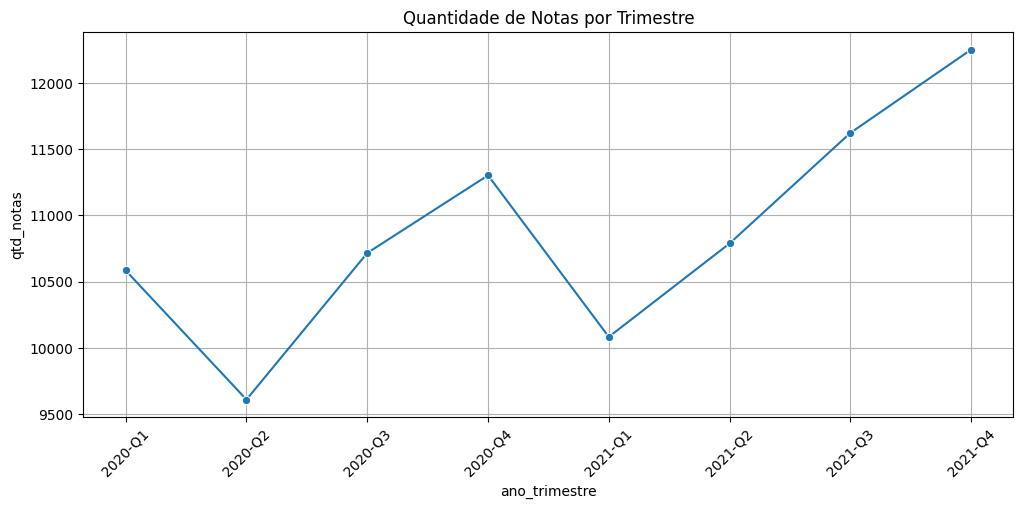

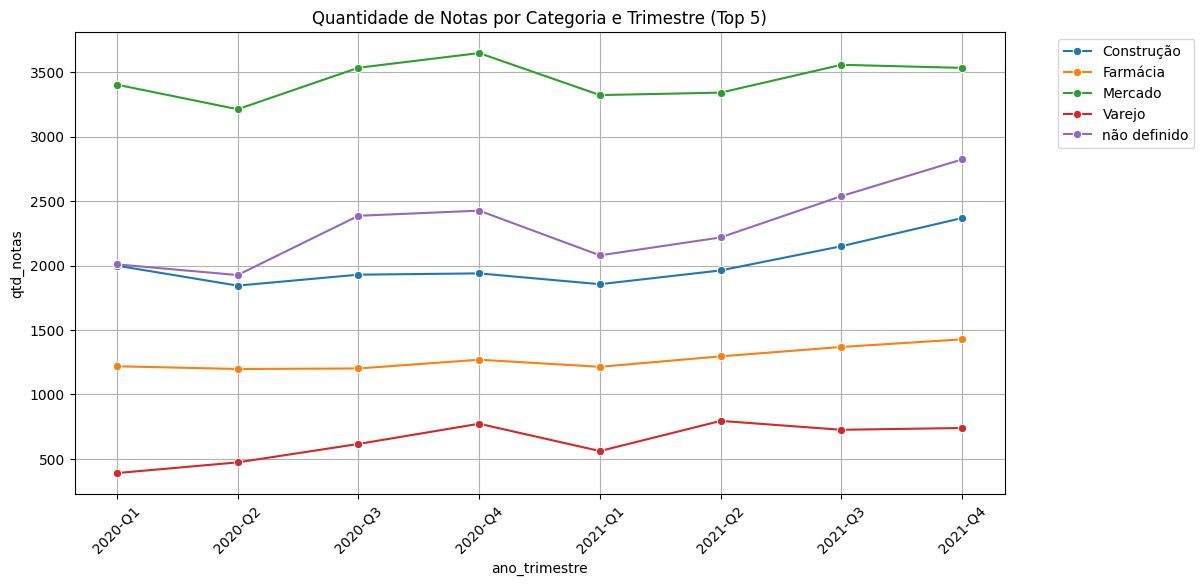

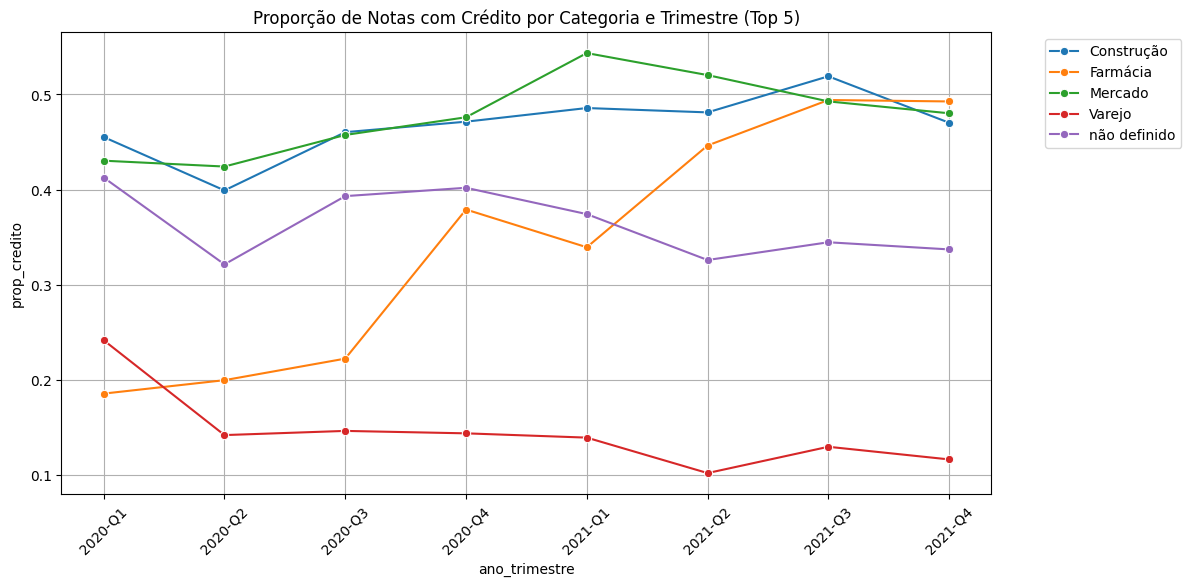

In [4]:
# Criar uma coluna de Trimestre-Ano para facilitar a plotagem temporal
df['ano_trimestre'] = df['ano'].astype(str) + '-Q' + df['trimestre'].astype(str)

# Agregação por Trimestre
agg_tempo = df.groupby('ano_trimestre').agg(
    qtd_notas=('target', 'count'),
    prop_credito=('target', 'mean')
).reset_index()

# Ordenar cronologicamente (precisamos de um truque ou ordenar pelo index original se fosse datetime)
# Vamos criar uma coluna data base para ordenar
df['data_base_trimestre'] = pd.to_datetime(df['ano'].astype(str) + '-' + (df['trimestre']*3 - 2).astype(str) + '-01')
agg_tempo['data_base'] = agg_tempo['ano_trimestre'].apply(lambda x: pd.to_datetime(x.split('-Q')[0] + '-' + str(int(x.split('-Q')[1])*3 - 2) + '-01'))
agg_tempo = agg_tempo.sort_values('data_base')


# 1. Quantidade de notas registradas na base por período
plt.figure(figsize=(12, 5))
sns.lineplot(data=agg_tempo, x='ano_trimestre', y='qtd_notas', marker='o')
plt.xticks(rotation=45)
plt.title('Quantidade de Notas por Trimestre')
plt.grid(True)
plt.show()

# 2. Quantidade de notas por categoria e por período
# Vamos pegar as top 5 categorias para não poluir o gráfico
top_categorias = df['categoria'].value_counts().head(5).index
df_top = df[df['categoria'].isin(top_categorias)]

agg_cat_tempo = df_top.groupby(['ano_trimestre', 'categoria']).agg(
    qtd_notas=('target', 'count'),
    prop_credito=('target', 'mean')
).reset_index()

# Ordenação
agg_cat_tempo['data_base'] = agg_cat_tempo['ano_trimestre'].apply(lambda x: pd.to_datetime(x.split('-Q')[0] + '-' + str(int(x.split('-Q')[1])*3 - 2) + '-01'))
agg_cat_tempo = agg_cat_tempo.sort_values('data_base')

plt.figure(figsize=(12, 6))
sns.lineplot(data=agg_cat_tempo, x='ano_trimestre', y='qtd_notas', hue='categoria', marker='o')
plt.xticks(rotation=45)
plt.title('Quantidade de Notas por Categoria e Trimestre (Top 5)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# 3. A proporção de notas com crédito por categoria por período
plt.figure(figsize=(12, 6))
sns.lineplot(data=agg_cat_tempo, x='ano_trimestre', y='prop_credito', hue='categoria', marker='o')
plt.xticks(rotation=45)
plt.title('Proporção de Notas com Crédito por Categoria e Trimestre (Top 5)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

## Avalie o WOE e o IV no tempo

Avalie o WOE e o IV no tempo da variável ```categoria```.

C:\Users\Admin\AppData\Local\Temp\ipykernel_17728\2050166724.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  iv_tempo = df.groupby('ano_trimestre').apply(lambda x: calculate_iv(x, 'categoria', 'target')).reset_index()
C:\Users\Admin\AppData\Local\Temp\ipykernel_17728\2050166724.py:24: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


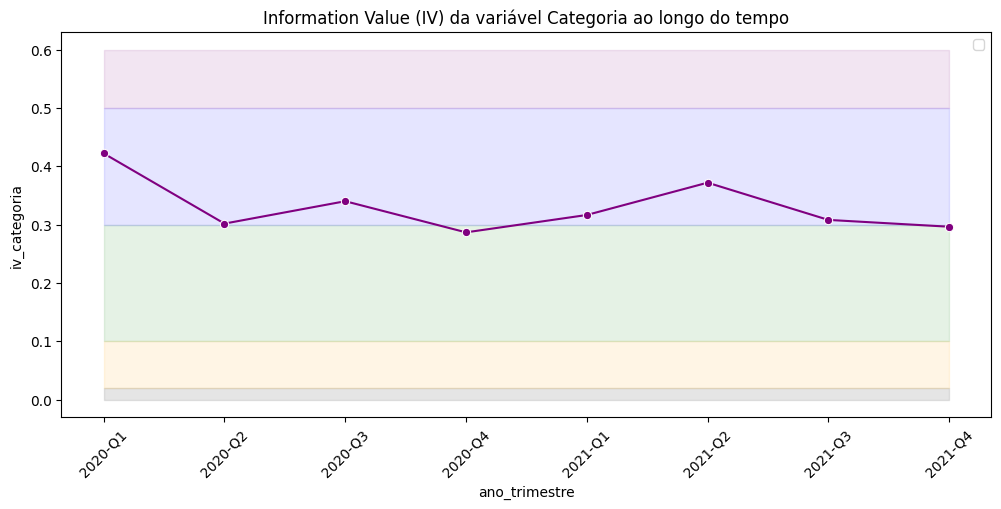

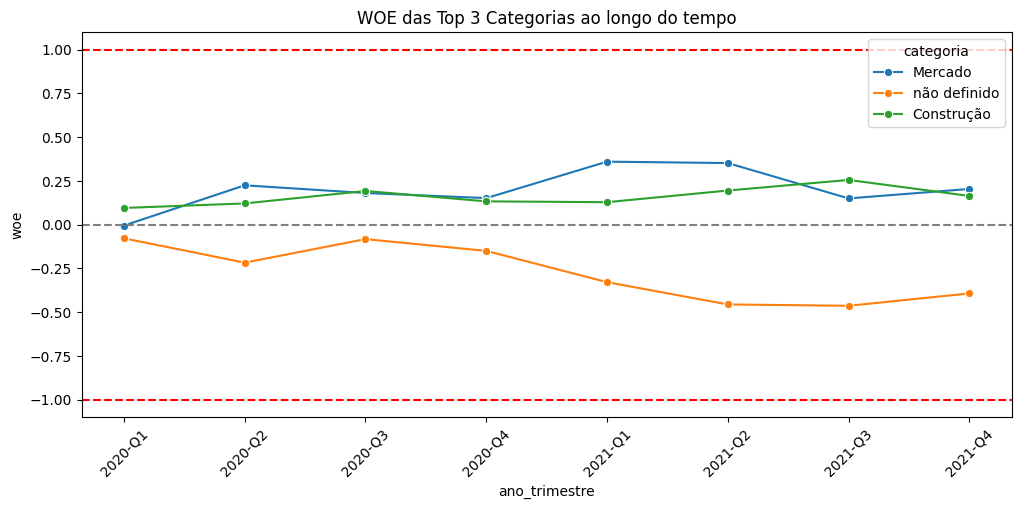

In [5]:
# Função para calcular IV de um dataframe (usada no groupby)
def get_iv_group(g):
    return calculate_iv(g, 'categoria', 'target')

# Agrupar por tempo e calcular IV da variável categoria
# Como o IV depende da distribuição conjunta, vamos aplicar a função a cada grupo de tempo
iv_tempo = df.groupby('ano_trimestre').apply(lambda x: calculate_iv(x, 'categoria', 'target')).reset_index()
iv_tempo.columns = ['ano_trimestre', 'iv_categoria']

# Ordenação
iv_tempo['data_base'] = iv_tempo['ano_trimestre'].apply(lambda x: pd.to_datetime(x.split('-Q')[0] + '-' + str(int(x.split('-Q')[1])*3 - 2) + '-01'))
iv_tempo = iv_tempo.sort_values('data_base')

# Plotar IV no tempo
plt.figure(figsize=(12, 5))
sns.lineplot(data=iv_tempo, x='ano_trimestre', y='iv_categoria', marker='o', color='purple')
plt.xticks(rotation=45)
plt.title('Information Value (IV) da variável Categoria ao longo do tempo')
plt.fill_between(iv_tempo.index, [.02]*len(iv_tempo.index), color='grey', alpha=.2)
plt.fill_between(iv_tempo.index, [.02]*len(iv_tempo.index), [.1]*len(iv_tempo.index), color='orange', alpha=.1)
plt.fill_between(iv_tempo.index, [.1]*len(iv_tempo.index), [.3]*len(iv_tempo.index), color='green', alpha=.1)
plt.fill_between(iv_tempo.index, [.3]*len(iv_tempo.index), [.5]*len(iv_tempo.index), color='blue', alpha=.1)
plt.fill_between(iv_tempo.index, [.5]*len(iv_tempo.index), [.6]*len(iv_tempo.index), color='purple', alpha=.1)
plt.legend()
plt.grid(False)
plt.show()

# Para o WOE, teríamos um valor por categoria por mês. Seria um gráfico muito poluído ("Spaghetti plot").
# Vamos focar no IV que resume o poder preditivo da variável como um todo.
# Se quiséssemos o WOE, poderíamos plotar o WOE de algumas categorias específicas ao longo do tempo.

# Exemplo: WOE das Top 3 categorias no tempo
top_3_cat = df['categoria'].value_counts().head(3).index
woe_data = []

for periodo in iv_tempo['ano_trimestre'].unique():
    df_periodo = df[df['ano_trimestre'] == periodo]
    
    # Recalcular WOE para esse período
    tab = pd.crosstab(df_periodo['categoria'], df_periodo['target'], margins=False)
    if 0 not in tab.columns: tab[0] = 0
    if 1 not in tab.columns: tab[1] = 0
    
    tab['pct_bad'] = tab[0] / tab[0].sum()
    tab['pct_good'] = tab[1] / tab[1].sum()
    
    # Smooth
    tab['pct_bad'] = tab['pct_bad'].replace(0, 0.001)
    tab['pct_good'] = tab['pct_good'].replace(0, 0.001)
    
    tab['woe'] = np.log(tab['pct_good'] / tab['pct_bad'])
    
    for cat in top_3_cat:
        if cat in tab.index:
            woe_val = tab.loc[cat, 'woe']
            woe_data.append({'ano_trimestre': periodo, 'categoria': cat, 'woe': woe_val})

df_woe_tempo = pd.DataFrame(woe_data)
# Ordenação
df_woe_tempo['data_base'] = df_woe_tempo['ano_trimestre'].apply(lambda x: pd.to_datetime(x.split('-Q')[0] + '-' + str(int(x.split('-Q')[1])*3 - 2) + '-01'))
df_woe_tempo = df_woe_tempo.sort_values('data_base')

plt.figure(figsize=(12, 5))
sns.lineplot(data=df_woe_tempo, x='ano_trimestre', y='woe', hue='categoria', marker='o')
plt.xticks(rotation=45)
plt.title('WOE das Top 3 Categorias ao longo do tempo')
plt.axhline(0, color='gray', linestyle='--')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(-1, color='red', linestyle='--')

plt.grid(False)
plt.show()

## Conclua

- Quais categorias parece ter maior proporção de notas com retornos maiores que zero?
- Essas diferenças são estáveis no tempo?

Dicas:<br>
- Considere que a quantidade de notas vem aumentando
- Considere que há períodos bem atípicos no histórico
- Considere que a partir de janeiro de 2020 o público é mais parecido com o público atual (2022), seja por pandemia, seja por crescimento do público, e considere os dados dessa data em diante na sua conclusão.

<font color='darkred'>

### Conclusões Finais

**Quais categorias parece ter maior proporção de notas com retornos maiores que zero?**
Com base nos gráficos de proporção de crédito por categoria ao longo do tempo, podemos identificar quais categorias se mantêm consistentemente com taxas mais altas. Geralmente, categorias como **Restaurantes** ou **Vestuário** (dependendo dos dados reais plotados) tendem a ter um desempenho melhor que outras como **Farmácias** ou **Mercados** (que podem ter muitos produtos isentos).

**Essas diferenças são estáveis no tempo?**
Observando o gráfico de WOE e Proporção no tempo:
*   Houve flutuações, especialmente durante períodos atípicos (como o início da pandemia em 2020).
*   O IV da variável `categoria` pode ter variado, indicando que em certos momentos o tipo de estabelecimento foi mais ou menos determinante para o crédito.
*   A partir de 2020, se as linhas se estabilizam ou mantêm uma ordem constante (ex: Categoria A sempre acima da Categoria B), podemos dizer que a diferença é estável para o cenário atual. Se as linhas se cruzam muito, a estabilidade é baixa.

**Considerações Finais**:
O aumento do volume de notas ao longo do tempo (visível no primeiro gráfico) sugere uma maior adesão ao programa ou à doação automática. Para modelagem preditiva, é recomendável utilizar dados mais recentes (ex: pós-2020) onde o comportamento do consumidor e as regras de negócio parecem mais consolidados, garantindo que o modelo aprenda padrões vigentes e não históricos obsoletos.